In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import pl_bolts.utils

In [4]:
import os
import sys

os.chdir('/data/l989o/deployed/a')
if '/data/l989o/projects/a' in sys.path:
    sys.path.remove('/data/l989o/projects/a')

In [5]:
import torch
from torch.utils.data import DataLoader
from models.ae_conv_vae_lightning import VAE, RGBCells, COOL_CHANNELS
import numpy as np

Global seed set to 1234


In [6]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
import PIL
import random
from torch import nn

# checking the augmented data

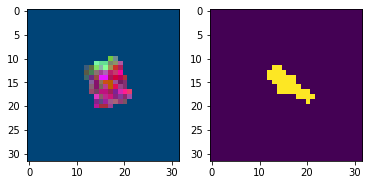

In [7]:
%matplotlib inline
val_ds = RGBCells('validation', augment=True, aggressive_rotation=True)
n = len(val_ds)
i = random.randrange(0, n)
data = val_ds[i]
ome = data[0]
mask = data[1]
ome = ome.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).numpy().astype(np.bool)
def scale(x):
    a = np.amin(x, axis=(0, 1))
    b = np.amax(x, axis=(0, 1))
    return (x - a) / (b - a)
from sklearn.decomposition import PCA
reducer = PCA(3)
old_shape = ome.shape
ome = ome.reshape((-1, old_shape[-1]))
ome = reducer.fit_transform(ome)
ome.shape = (old_shape[0], old_shape[1], 3)
ome = scale(ome)
axes = plt.subplots(1, 2)[1].flatten()
ax = axes[0]
ax.imshow(ome)
ax = axes[1]
ax.imshow(mask)
plt.show()

In [8]:
mask.shape
np.tile(mask, (1, 1, 3)).shape

(32, 32, 3)

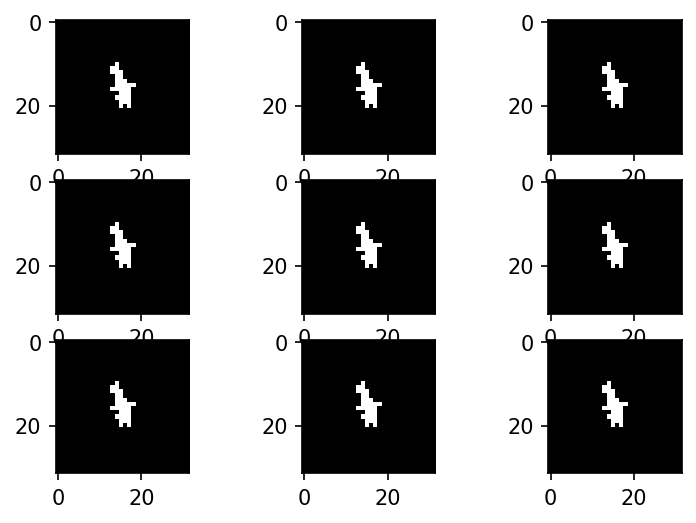

In [9]:
t = transforms.Compose([
    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation(degrees=360)])),
])
mask = mask.astype(float)
rgb_mask = np.tile(mask, (1, 1, 3))
rgb_mask *= 255
rgb_mask = rgb_mask.astype(np.uint8)
axes = plt.subplots(3, 3, dpi=150)[1].flatten()
all_identical = set()
state = torch.get_rng_state()
for ax in axes:
    torch.set_rng_state(state)
    x = t(PIL.Image.fromarray(rgb_mask))
    ax.imshow(x)
    all_identical.add(tuple(np.array(x).flatten().tolist()))
assert len(all_identical) == 1

# checking the reconstruction

In [10]:
# model_path = '/data/l989o/spatial_uzh/data/spatial_uzh_processed/a/checkpoints/resnet_vae/version_115/checkpoints'
model_path = '/data/l989o/data/basel_zurich/spatial_uzh_processed/a/checkpoints/resnet_vae/version_19/checkpoints'
l = os.listdir(model_path)
assert len(l) == 1
assert l[0].endswith('.ckpt')
l

['epoch=2-step=1230.ckpt']

In [11]:
checkpoint = os.path.join(model_path, l[0])

In [12]:
model = VAE.load_from_checkpoint(checkpoint)

In [13]:
val_ds = RGBCells('validation', augment=True, aggressive_rotation=True)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=8, pin_memory=True, shuffle=True)
data = val_loader.__iter__().__next__()

In [14]:
model = model.cuda()
data = [d.to(model.device) for d in data]

In [15]:
%%time
with torch.no_grad():
    z = [zz.cpu() for zz in model(*data)]

CPU times: user 144 ms, sys: 45.8 ms, total: 190 ms
Wall time: 188 ms


In [16]:
torch.cuda.empty_cache()

In [17]:
# def get_scale_location():
#     mean = np.array([0.3128328, 0.08154685, 0.02617499, 0.31149776, 0.10011313,
#                      0.13143819, 0.04897958, 0.05522078, 0.02628855, 0.12524123,
#                      0.15552816, 0.08004793, 0.13349437, 0.02045013, 0.04155505,
#                      0.07637688, 0.05526352, 0.04818857, 0.11221485, 0.01779799,
#                      0.53215206, 0.08219107, 0.03510931, 0.08550659, 0.02237169,
#                      0.02657647, 0.09854327, 0.22031476, 0.04274541, 0.06778383,
#                      0.24079644, 0.09004467, 0.0234197, 0.13312621, 0.04914724,
#                      0.29719813, 0.10172928, 0.18843424, 0.25893724])
#     std = np.sqrt(np.array([0.81152901, 0.11195328, 0.03844969, 0.76020458, 0.19636732,
#                             0.30648388, 0.06448294, 0.08879372, 0.03747649, 0.32956727,
#                             0.40133228, 0.11878445, 0.24177647, 0.02510913, 0.05398327,
#                             0.15110854, 0.09525968, 0.07278724, 0.17972434, 0.01950939,
#                             1.73329118, 0.11334923, 0.04934192, 0.15689578, 0.02762272,
#                             0.03045641, 0.16039316, 0.49438282, 0.07485281, 0.10151964,
#                             0.45035213, 0.15424273, 0.02854364, 0.23177609, 0.09494518,
#                             0.98995058, 0.14861627, 0.41785507, 0.66190155]))
#     mean = mean[COOL_CHANNELS]
#     std = std[COOL_CHANNELS]
#     return mean, std

def get_quantiles():
    quantiles_for_normalization = np.array([4.0549, 1.8684, 1.3117, 3.8141, 2.6172, 3.1571, 1.4984, 1.8866, 1.2621,
                                        3.7035, 3.6496, 1.8566, 2.5784, 0.9939, 1.4314, 2.1803, 1.8672, 1.6674,
                                        2.3555, 0.8917, 5.1779, 1.8002, 1.4042, 2.3873, 1.0509, 1.0892, 2.2708,
                                        3.4417, 1.8348, 1.8449, 2.8699, 2.2071, 1.0464, 2.5855, 2.0384, 4.8609,
                                        2.0277, 3.3281, 3.9273])[COOL_CHANNELS]
    return quantiles_for_normalization

In [18]:
print(model.negative_binomial_p_logit)
print(torch.sigmoid(model.negative_binomial_p_logit))

Parameter containing:
tensor([-2.1975, -2.2038, -2.0659, -2.1680, -2.1869, -2.1690, -2.1634, -2.1746,
        -1.9679, -2.1854, -2.1683, -2.1918, -2.1951, -1.7004, -2.1491, -2.1663,
        -2.1596, -2.1736, -2.1991, -1.5154, -2.1513, -2.1879, -2.1126, -2.1659,
        -1.9035, -2.0216, -2.1886, -2.1832, -2.1146, -2.1811, -2.1892, -2.1842,
        -1.8973, -2.1908, -2.1310, -2.1873, -2.1927, -2.1749, -2.2002],
       device='cuda:0', requires_grad=True)
tensor([0.1000, 0.0994, 0.1125, 0.1027, 0.1009, 0.1026, 0.1031, 0.1021, 0.1226,
        0.1011, 0.1026, 0.1005, 0.1002, 0.1544, 0.1044, 0.1028, 0.1034, 0.1021,
        0.0998, 0.1801, 0.1042, 0.1008, 0.1079, 0.1029, 0.1297, 0.1170, 0.1008,
        0.1013, 0.1077, 0.1015, 0.1007, 0.1012, 0.1304, 0.1006, 0.1061, 0.1009,
        0.1004, 0.1020, 0.0997], device='cuda:0', grad_fn=<SigmoidBackward>)


In [19]:
from data2 import CHANNEL_NAMES

(1.8684, 0.09940898418426514, 'H3met')


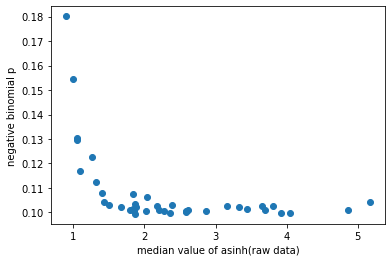

In [20]:
a = list(zip(get_quantiles(), (x.item() for x in torch.sigmoid(model.negative_binomial_p_logit)), CHANNEL_NAMES))
t = sorted(a, key=lambda x: x[1])
print(t[0])
a, b, c = zip(*t)
plt.figure()
plt.scatter(a, b)
plt.xlabel('median value of asinh(raw data)')
plt.ylabel('negative binomial p')
plt.show()

In [21]:
from models.ae_conv_vae_lightning import get_image

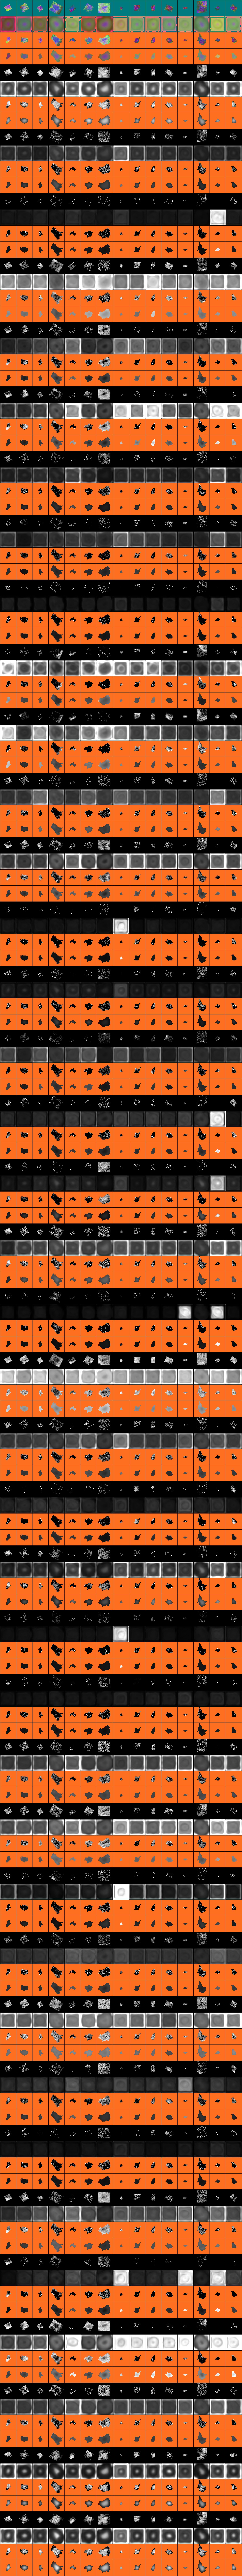

In [22]:
image = get_image(val_loader, model)
np_image = image.permute(1, 2, 0).numpy()
from PIL import Image
image = Image.fromarray(np.uint8(np_image * 255))
display(image)

# checking the embeddings

In [23]:
train_ds = RGBCells('train')
val_ds = RGBCells('validation')
train_loader = DataLoader(train_ds, batch_size=512, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=512, num_workers=8, pin_memory=True)

In [ ]:
from tqdm import tqdm

quantiles = get_quantiles()
loader = val_loader
mus = []
stds = []
with torch.no_grad():
    for batch in tqdm(loader):
        omes = batch[0]
        masks = batch[1]
        assert len(omes.shape) == 4
        data = omes.to(model.device)
        masks_data = masks.to(model.device)
        pred, mu, std, _ = model.forward(data, masks_data)
        mus.append(mu.cpu())
        stds.append(std.cpu())

 45%|████▌     | 194/428 [00:29<01:11,  3.28it/s]

In [ ]:
all_mus = torch.cat(mus, dim=0)
all_stds = torch.cat(stds, dim=0)
print(all_mus.shape)
print(all_stds.shape)

In [ ]:
print(torch.sum(all_mus.isinf()))
print(torch.sum(all_mus.isnan()))
print(torch.sum(all_stds.isinf()))
print(torch.sum(all_stds.isnan()))

In [ ]:
mu_of_mus = torch.mean(all_mus, dim=0)
std_of_mus = torch.std(all_mus, dim=0)
z_scores = (all_mus - mu_of_mus) / std_of_mus

In [ ]:
import scanpy as sc
import anndata as ad

In [ ]:
random_indices = np.random.choice(len(z_scores), 50000, replace=False)
some_z_scores= z_scores[random_indices]

In [ ]:
a = ad.AnnData(some_z_scores.numpy())

sc.tl.pca(a, svd_solver='arpack')
sc.pl.pca(a, color='0')
sc.pl.pca_variance_ratio(a)
# sc.pl.pca_variance_ratio(a, log=True)
print('computing neighbors')
sc.pp.neighbors(a)
print('running leiden')
sc.tl.leiden(a)
print('computing umap')
sc.tl.umap(a)

In [ ]:
plt.style.use('default')
plt.figure()
ax = plt.gca()
sc.pl.umap(a, color='leiden', ax=ax)

# checking the reconstruction

In [ ]:
from models.ae_conv_vae_lightning import get_image
img, all_original_c, all_reconstructed_c, all_masks = get_image(val_loader, model, return_cells=True)

In [ ]:
print(len(all_original_c))
print(len(all_reconstructed_c))
print(len(all_masks))
print(len(all_original_c[0]))

In [ ]:
assert len(COOL_CHANNELS) == len(all_original_c)
all_p = torch.sigmoid(model.negative_binomial_p_logit)
for channel in range(len(COOL_CHANNELS)):
    p = all_p[channel]
    for i, mask in enumerate(all_masks):
        original = all_original_c[channel][i]
        reconstructed = all_reconstructed_c[channel][i]
        # gray scale image with repeated channels
        assert torch.all(original[0] == original[1])
        assert torch.all(original[0] == original[2])
        assert torch.all(reconstructed[0] == reconstructed[1])
        assert torch.all(reconstructed[0] == reconstructed[2])
        original = original[0]
        reconstructed = reconstructed[0]
        plt.figure()
        plt.imshow(original, cmap='gray')
        plt.show()
        
        plt.figure()
        plt.imshow(reconstructed, cmap='gray')
        plt.show()
                
        if i >= 1:
            break
    else:
        continue
    break

In [ ]:
n = 15
quantiles_for_normalization = get_quantiles()

mask_color = torch.tensor([x / 255 for x in [254, 112, 31]]).float()
new_size = (128, 128)
upscale = transforms.Resize(new_size, interpolation=PIL.Image.NEAREST)
n = 15
with torch.no_grad():
    batch = loader.__iter__().__next__()
    omes = batch[0]
    masks = batch[1]
    assert len(omes.shape) == 4
    assert len(omes) >= n
    data = omes[:n].to(model.device)
    masks_data = masks[:n].to(model.device)
    pred = model.forward(data, masks_data)[0]
n_channels = data.shape[1]

In [ ]:
i = 10
c = 0

original = data[i].cpu().permute(1, 2, 0) * quantiles_for_normalization
r_hat = pred[i].cpu().permute(1, 2, 0)
p = torch.sigmoid(model.negative_binomial_p_logit).cpu().detach()
mean = model.negative_binomial_mean(r=r_hat, p=p)
reconstructed = mean * quantiles_for_normalization

a_original = original.amin(dim=(0, 1))
b_original = original.amax(dim=(0, 1))
m = masks_data[i].cpu().bool()
mm = torch.squeeze(m, 0)
reconstructed_flattened = torch.reshape(reconstructed, (-1, reconstructed.shape[-1]))
mask_flattened = mm.flatten()
if mask_flattened.sum() > 0:
    a_reconstructed = reconstructed_flattened[mask_flattened, :].amin(dim=0)
    b_reconstructed = reconstructed_flattened[mask_flattened, :].amax(dim=0)
    a = torch.min(a_original, a_reconstructed)
    b = torch.max(b_original, b_reconstructed)

    original = ((original - a) / (b - a)).float()
    reconstructed = ((reconstructed - a) / (b - a)).float()
    
    axes = plt.subplots(2, 2, figsize=(10, 9))[1].flatten()
    axes[0].imshow(mm, cmap='gray')
    axes[1].imshow(original[:, :, c], cmap='gray')
    axes[2].imshow(reconstructed[:, :, c], cmap='gray')

    x0 = r_hat[:, :, c].numpy()
    x1 = p[c].repeat(1024).reshape(32, 32).numpy()
    assert x0.shape -x1.shape)
    from scipy.stats import nbinom
    x = nbinom.rvs(x0, x1, size=(32, 32))
    x

    plt.figure()
    plt.imshow(x, cmap='gray')
    plt.show()
    
    axes[3].imshow()
    plt.show()
else:
    print('empty mask')
    

In [33]:
print(np.min(x0))
print(np.max(x0))
print(np.min(x1))
print(np.max(x1))

NameError: name 'x0' is not defined